# Confidence Interval of Estimated Parameters

After obtaining the *best* fit, it is natural to report both the point
estimate and the confidence level at the $\alpha$ level. The easiest way
to do this is by invoking the normality argument and use Fisher
information of the likelihood. As explained previously at the bottom of
{ref}`gradient:hessian`, we can find the Hessian, $\mathbf{H}$, or the approximated
Hessian for the estimated parameters. From the Cramer--Rao 

#TODO add ref

inequality, we
know that

$$Var(\hat{\theta}) \ge \frac{1}{I(\theta)},$$

where $I(\theta)$ is the Fisher information, which is the Hessian
subject to regularity condition. Given the Hessian, computing the
confidence intervals is trivial. Note that this is also known as the
asymptotic confidence interval where the normality comes from invoking
the CLT. There are other ways of obtaining a confidence intervals, we
will the ones implemented in the package. First, we will set up a SIR
model as seen in {doc}`sir` which will be used throughout this page.

In [1]:
from pygom import NormalLoss, common_models

from pygom.utilR import qchisq

import numpy

import scipy.integrate

import matplotlib.pyplot as plt

import copy

ode = common_models.SIR([('beta', 0.5), ('gamma', 1.0/3.0)])


and we assume that we only have observed realization from the $R$
compartment

In [2]:
x0 = [1, 1.27e-6, 0]

t = numpy.linspace(0, 150, 100).astype('float64')

ode.initial_values = (x0, t[0])

solution = ode.integrate(t[1::])

theta = [0.2, 0.2]

targetState = ['R']

targetStateIndex = numpy.array(ode.get_state_index(targetState))

y = solution[1::,targetStateIndex] + numpy.random.normal(0,0.01, (len(solution[1::,targetStateIndex]), 1))

yObv = y.copy()

objSIR = NormalLoss(theta, ode, x0, t[0], t[1::], y, targetState)

boxBounds = [(1e-8, 2.0), (1e-8, 2.0)]

boxBoundsArray = numpy.array(boxBounds)

xhat = objSIR.fit(theta, lb=boxBoundsArray[:,0], ub=boxBoundsArray[:,1])



## Asymptotic

When the estimate is obtained say, under a square loss or a normal
assumption, the corresponding likelihood can be written down. In
such a case, the likelihood ratio test under a Chi--squared distribution is

$$2 (\mathcal{L}(\hat{\boldsymbol{\theta}}) - \mathcal{L}(\boldsymbol{\theta})) \le \chi_{1 - \alpha}^{2}(k)$$

where $1-\alpha$ is the size of the confidence region and $k$ is the
degree of freedom. The corresponding asymptotic confidence interval for
parameter $j$ can be derived as

$$\hat{\theta}_{j} \pm \sqrt{\chi_{1 - \alpha}^{2}(k) H_{i,i}}.$$

A point-wise confidence interval is obtained when $k = 1$. We assume in
our package that a point-wise confidence interval is desired. This can be
obtained with the following steps.


In [3]:
from pygom import confidence_interval as ci

alpha = 0.05

xL, xU = ci.asymptotic(objSIR, alpha, xhat, lb=boxBoundsArray[:,0], ub=boxBoundsArray[:,1])

print(xL)
print(xU)

[0.30563305 0.15211495]
[0.69392383 0.51349773]


'''{warning}
Note that the set of bounds here is only used for check the validity of
$\hat{\mathbf{x}}$ and not used in the calculation of the confidence
intervals. Therefore the resulting output can be outside of the box
constraints.
```


## Profile Likelihood

Another approach to calculate the confidence interval is to tackle one
parameter at a time, treating the rest of them as nuisance parameters,
hence the term *profile*. Let $\mathcal{L}(\boldsymbol{\theta})$ be our
log--likelihood with parameter $\boldsymbol{\theta}$. Element
$\theta_{j}$ is our parameter of interest and $\boldsymbol{\theta}_{-j}$
represents the complement such that
$\boldsymbol{\theta} = \theta_{j} \cup \boldsymbol{\theta}_{-j}$. For
simply models such as linear regression with only regression
coefficients $\boldsymbol{\beta}$, then
$\boldsymbol{\theta} = \boldsymbol{\beta}$.

To shorten the notation, let

$$\mathcal{L}(\boldsymbol{\theta}_{-j} \mid \theta_{j}) = \max \mathcal{L}(\boldsymbol{\theta}_{-j} \mid \theta_{j})$$

which is the maxima of $\boldsymbol{\theta}_{-j}$ given $\theta_{j}$.
$\hat{\boldsymbol{\theta}}$ denotes the MLE of the parameters as usual.
The profile--likelihood based confidence interval for $\theta_{j}$ is
defined as

$$\begin{aligned}
\theta_{j}^{U} &= \sup \left\{ \mathcal{L}(\hat{\boldsymbol{\theta}}) - \mathcal{L}(\boldsymbol{\theta} \mid \theta_{j}) \le \frac{1}{2} \chi_{1 - \alpha}^{2}(1) \right\} \\
\theta_{j}^{L} &= \inf \left\{ \mathcal{L}(\hat{\boldsymbol{\theta}}) - \mathcal{L}(\boldsymbol{\theta} \mid \theta_{j}) \le \frac{1}{2} \chi_{1 - \alpha}^{2}(1) \right\}
\end{aligned}$$

where again we have made use of the normal approximation, but without
imposing symmetry. The set of equations above automatically implies that
the interval width is $\theta_{j}^{U} - \theta_{j}^{L}$ and

$$\mathcal{L}(\hat{\boldsymbol{\theta}}) - \frac{1}{2} \chi_{1-\alpha}^{2}(1) - \mathcal{L}(\boldsymbol{\theta} \mid \theta_{j}) = 0.$$

As mentioned previously, $\boldsymbol{\theta}_{-j}$ is the maximizer of
the nuisance parameters, which has a gradient of zero. Combining this
with the equation above yields a non-linear system of equations of size
$p$,

$$\begin{aligned}
g(\boldsymbol{\theta}) = \left[ \begin{array}{c} \mathcal{L}(\boldsymbol{\theta} \mid \theta_{j}) - c \\ \frac{\partial \mathcal{L}(\boldsymbol{\theta} \mid \theta_{j})}{\partial \boldsymbol{\theta}_{-j}} \end{array} \right] = 0
\end{aligned}$$

where
$c = \mathcal{L}(\hat{\boldsymbol{\theta}}) + \frac{1}{2} \chi_{1-\alpha}^{2}(1)$.
Solving this set of system of equations only need simple Newton like
steps, possibly with correction terms as per {cite:t}`Venzon1988`. We
provide a function to obtain such estimate, {func}`ci.profile`

In [4]:
xLProfile, xUProfile, xLProfileList, xUProfileList = ci.profile(objSIR, alpha, xhat, lb=boxBoundsArray[:,0], ub=boxBoundsArray[:,1], full_output=True)

but unfortunately this is not accurate most of the time due to the
complicated surface at locations not around $\hat{\theta}$. This is a
common scenario for non--linear least square problems because the
Hessian is not guaranteed to be a PSD everywhere. Therefore, a safeguard
is in place to obtain the $\theta_{j}^{U},\theta_{j}^{L}$ by iteratively updating $\theta_{j}$ and find the solution to `nuisanceOptim`.

#TODO what is nuisance optim?

Furthermore, we also provide the functions necessary to obtain the
estimates such as the four below.

In [5]:
i = 0

funcF = ci._profileF(xhat, i, 0.05, objSIR)

funcG = ci._profileG(xhat, i, 0.05, objSIR)

funcGC = ci._profileGSecondOrderCorrection(xhat, i, alpha, objSIR)

funcH = ci._profileH(xhat, i, 0.05, objSIR)

Where $i$ is the index of the parameter of interest. {func}`_profileF` is the
squared norm of {obj}`obj`, which easy the optimization process for solvers
which requires a converted form from system of equations to non-linear
least squares. {func}`_profileG` is the system of equations of {obj}`obj`,
and {func}`_profileH` is the derivative of {obj}`obj`.

$$\begin{aligned}
\nabla g(\boldsymbol{\theta}) = \left[ \begin{array}{c} \frac{\partial \mathcal{L}(\boldsymbol{\theta} \mid \theta_{j})}{\partial \theta_{j}} \\ \frac{\partial^{2} \mathcal{L}(\boldsymbol{\theta} \mid \theta_{j})}{\partial \boldsymbol{\beta}_{-j} \partial \theta_{j}} \end{array} \right]
\end{aligned}$$

{func}`_profileGSecondOrderCorrection` is the second order correction {cite}Venzon1988.

## Geometric profile likelihood

Due to the difficulty in obtain a profile likelihood via the standard
Newton like steps, we also provide a way to generate a similar result
using the geometric structure of the likelihood surface. We follow the
method in {cite:t}`Moolgavkar1987`, which involves solving a set of
differential equations

$$\begin{aligned}
\frac{d\beta_{j}}{dt} &= k g^{-1/2} \\
\frac{d\boldsymbol{\beta}_{-j}}{dt} &= \frac{d\boldsymbol{\beta}_{-j}}{d\beta_{j}} \frac{d\beta_{j}}{dt},
\end{aligned}$$

where $k = \Phi(1-\alpha)$ is the quantile we want to obtain under a
normal distribution, and

$$\begin{aligned}
g = J_{\beta_{j}}^{\top} I^{\boldsymbol{\beta}} J_{\beta_{j}}, \quad J_{\beta_{j}} = \left( \begin{array}{c} 1 \\ \frac{d\boldsymbol{\beta}_{-j}}{d\beta_{j}} \end{array} \right).
\end{aligned}$$

Here, $J_{\beta_{j}}$ is the Jacobian between $\beta_{j}$ and
$\boldsymbol{\beta}_{-j}$ with the term

$$\frac{d\boldsymbol{\beta}_{-j}}{d\beta_{j}} = -\left( \frac{\partial^{2} \mathcal{L}}{\partial \boldsymbol{\beta}_{-j}\partial \boldsymbol{\beta}_{-j}^{\top} } \right)^{-1} \frac{\partial^{2} \mathcal{L}}{\partial \beta_{j} \partial \beta_{-j}^{\top}}$$

and hence the first element is $1$ (identity transformation).
$I^{\boldsymbol{\beta}}$ is the Fisher information of
$\boldsymbol{\beta}$, which is

$$I^{\boldsymbol{\beta}} = \frac{\partial \boldsymbol{\theta}}{\partial \boldsymbol{\beta}^{\top}} \Sigma^{\boldsymbol{\theta}(\boldsymbol{\beta})} \frac{\partial \boldsymbol{\theta}}{\partial \boldsymbol{\beta}}.$$

It is simply $\Sigma^{\boldsymbol{\beta}}$ if
$\boldsymbol{\theta} = \boldsymbol{\beta}$. Different Fisher information
can be used for $\Sigma^{\boldsymbol{\beta}}$ such as the expected or
observed, at $\hat{\boldsymbol{\beta}}$ or $\boldsymbol{\beta}$. After
some trivial algebraic manipulation, we can show that our ODE boils
downs to

$$\begin{aligned}
\left[ \begin{array}{c} \frac{d\beta_{j}}{dt} \\ \frac{d\boldsymbol{\beta_{-j}}}{dt} \end{array} \right] = k \left[ \begin{array}{c} 1 \\ -A^{-1}w \end{array} \right] \left( v - w^{\top}A^{-1}w \right)^{-1/2}
\end{aligned}$$

where the symbols on the RHS above correspond to partitions in the
Fisher information

$$\begin{aligned}
I^{\boldsymbol{\beta}} = \left[ \begin{array}{cc} v & w^{\top} \\ w & A \end{array} \right].
\end{aligned}$$

The integration is perform from $t = 0$ to $1$ and is all handled
internally via {class}`geometric`.

In [6]:
xLGeometric, xUGeometric, xLList, xUList = ci.geometric(objSIR, alpha, xhat, full_output=True)

print(xLGeometric)
print(xUGeometric)

[0.21802959 0.04961695]
[1.26151364 1.06296231]



## Bootstrap

This is perhaps the favorite method to estimate confidence intervals for
a lot of people. Although there are many ways to implement bootstrap,
semi-parametric is the only logical choice (even though the underlying
assumptions may be violated at times). As we have only implemented OLS
type loss functions in this package, the parametric approach seem to be
inappropriate when there is no self-efficiency guarantee.
Non-parametric approaches requires at least a conditional independence
assumption, something easily violated by our **ODE**. Block bootstrap is
an option but we are also aware that the errors of an **ODE** can be
rather rigid, and consistently over/under estimate at certain periods of
time.

#TODO refs for bootstrap?

When we say semi-parametric, we mean the exchange of errors between the
observations. Let our raw error be

$$\varepsilon_{i} = y_{i} - \hat{y}_{i}$$

where $\hat{y}_{i}$ will be the prediction under
$\hat{\boldsymbol{\theta}}$ under our model. Then we construct a new set
of observations via

$$y_{i}^{\ast} = \hat{y}_{i} + \varepsilon^{\ast}, \quad \varepsilon^{\ast} \sim \mathcal{F}$$

with $\mathcal{F}$ being the empirical distribution of the raw errors. A
new set of parameters $\theta^{\ast}$ are then found for the
bootstrapped samples, and we obtain the $\alpha$ confidence interval by
taking the $\alpha/2$ quantiles. Invoking the corresponding python function
yields our bootstrap estimates. Unlike {func}`asymptotic`, the bounds here are
used when estimating the parameters of each bootstrap samples. An error
may be returned if estimation failed for any of the bootstrap samples.

In [7]:
xLBootstrap, xUBootstrap, setX = ci.bootstrap(objSIR, alpha, xhat, iteration=10, lb=boxBoundsArray[:,0], ub=boxBoundsArray[:,1], full_output=True)

print(xLBootstrap)
print(xUBootstrap)

[0.49842726 0.33142003]
[0.50466089 0.33727478]


The additional information here can be used to compute the bias, tail
effects and test against the normality assumption. If desired, a
simultaneous confidence interval can also be approximated empirically.
Note however that because we are using a semi-parameter method here, if
the model specification is wrong then the resulting estimates for the
bias is also wrong. The confidence interval still has the normal
approximation guarantee if the number of samples is large.

In this case, because the error in the observation is extremely small,
the confidence interval is narrow.

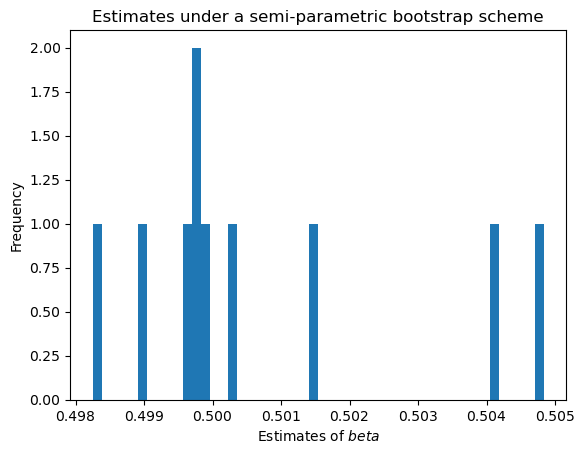

In [8]:
import pylab as P

f = plt.figure()

n, bins, patches = P.hist(setX[:,0], 50)

P.xlabel(r'Estimates of $beta$');

P.ylabel('Frequency');

P.title('Estimates under a semi-parametric bootstrap scheme');

P.show()




## Comparison Between Methods

Although we have shown the numerical values for the confidence interval
obtained using different methods, it can be hard to comprehend how they
vary. As they say, a picture says a million word, and given that this
particular model only has two parameters, we can obtain inspect and
compare the methods visually via a contour plot. The code to perform
this is shown below but the code block will not be run to save time and
space.

In the plot above, the bootstrap confidence interval were so close to
the MLE, it is impossible to distinguish the two on such a coarse scale.

Furthermore, because the geometric confidence interval is the result of
an integration, we can trace the path that lead to the final output that
was shown previously. Again, we are space conscious (and time
constrained) so the code block below will not be run.

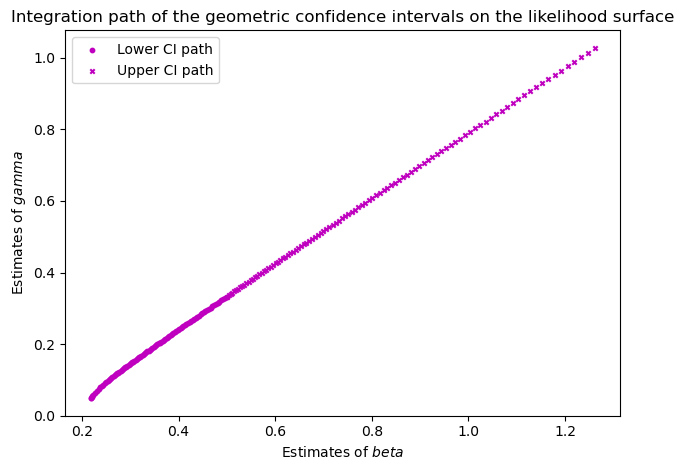

In [10]:
fig = plt.figure()

#CS = plt.contour(xi, yi, zi, linewidth=0.5)

#plt.clabel(CS, fontsize=10, inline=1)

l1 = plt.scatter(xLList[0][:,0], xLList[0][:,1], marker='o', c='m', s=10);

l2 = plt.scatter(xUList[0][:,0], xUList[0][:,1], marker='x', c='m', s=10);

plt.legend((l1, l2), ('Lower CI path', 'Upper CI path'), loc='upper left');

plt.ylabel(r'Estimates of $gamma$');

plt.xlabel(r'Estimates of $beta$');

plt.title('Integration path of the geometric confidence intervals on the likelihood surface');

plt.tight_layout();

plt.show()


## Profile Likelihood Surface

To investigate why it was hard to find the profile likelihood confidence
interval, we can look at the surface (which is a line as
we are profiling). We find the solution of {func}`nuisanceOptim` for each
$\boldsymbol{\theta}_{-j}$ at various points of $\boldsymbol{\theta}$.
Equivalently, we can minimize the original loss function as defined
previously, and this is the approach below. We focus out attention to
the parameter $\beta$ of our SIR model. The results are not shown here
but the existence of a solution to {obj}`obj` is evident by *eyeballing* the plots.

In [11]:
numIter = 100

x2 = numpy.linspace(0.0, 2.0, numIter)

funcOut = numpy.linspace(0.0, 2.0, numIter)

ode.parameters = [('beta',0.5), ('gamma',1.0/3.0)]

for i in range(numIter):
    paramEval = [('beta',x2[i]), ('gamma',x2[i])]
    ode2 = copy.deepcopy(ode) 
    ode2.parameters = paramEval
    ode2.initial_values = (x0, t[0])
    objSIR2 = NormalLoss(x2[i], ode2, x0, t[0], t[1::], yObv.copy(), targetState, target_param='gamma')
    res = scipy.optimize.minimize(fun=objSIR2.cost, jac=objSIR2.gradient, x0=x2[i], bounds=[(0,2)], method='L-BFGS-B')
    funcOut[i] = res['fun']

fig = plt.figure()

plt.plot(x2, objSIR.cost(xhat) - funcOut)

l1 = plt.axhline(-0.5*qchisq(1 - alpha, df=1), 0, 2, color='r')

plt.ylabel(r'\$mathcal{L}(hat{theta}) - mathcal{L}(theta mid beta)$');

plt.xlabel(r'Fixed value of $beta$');

plt.title('Difference in objective function between MLEn and the maximization of the nuisance parameters given then parameter of interest, beta in this case');

plt.tight_layout();

plt.legend((l1,), (r'$-0.5mathcal{X}_{1 - alpha}^{2}(1)$',), loc='lower right');

plt.show() 



Both the upper and lower confidence interval can be found in the
profiling procedure, but the part between of
$\beta \in \left[0,\hat{\beta}\right]$ is not convex, with $\hat{\beta}$
being the MLE. This non--quadratic profile likelihood is due to the
non-identifiability of the model given data {cite}`Raue2009`. For this
particular case, we can fix it simply by introducing additional
observations in the form of the $I$ state. We encourage the users to try
it out for themselves to confirm.

In [ ]:
targetState = \['I', 'R'\]

targetStateIndex = numpy.array(ode.get_state_index(targetState))

y = solution[1::,targetStateIndex] + numpy.random.normal(0, 0.01, (len(solution[1::,targetStateIndex]), 1))

objSIR = NormalLoss(theta, ode, x0, t[0], t[1::], y.copy(), targetState)

xhat = objSIR.fit(theta, lb=boxBoundsArray[:,0], ub=boxBoundsArray[:,1])

for i in range(numIter):  
    paramEval = [('beta', x2[i]), ('gamma', x2[i])] 
    ode2 = copy.deepcopy(ode)
    ode2.parameters = paramEval
    ode2.initial_values = (x0, t[0]) 
    objSIR2 = NormalLoss(x2[i], ode2, x0, t[0], t[1::], y.copy(), targetState, target_param='gamma')
    res = scipy.optimize.minimize(fun=objSIR2.cost, jac=objSIR2.gradient, x0=x2[i], bounds=[(0,2)], method='L-BFGS-B')
    funcOut[i] = res['fun']

fig = plt.figure()

plt.plot(x2, objSIR.cost(xhat) - funcOut);

l1 = plt.axhline(-0.5*qchisq(1 - alpha, df=1), 0, 2, color='r')

plt.ylabel(r'$mathcal{L}(hat{theta}) - mathcal{L}(theta mid beta)$');

plt.xlabel(r'Fixed value of $beta$');

plt.title('Profile likelihood curve for the parameter of interest with more observations');

plt.tight_layout();

plt.legend((l1,), (r'$-0.5mathcal{X}_{1 - alpha}^{2}(1)$',), loc='lower right');

plt.show()